# Importing the packages and dataset

In [0]:
import numpy as np
from tensorflow.examples.tutorials.mnist import input_data

# loading the MNIST dataset to memory and splitting it

### What's one_hot?
In MNIST, the labels are 0–9. You can either encode that as an integer, or in one-hot encoding where 


0=1000010000  |  5=0000010000

1=0100010000  |  6=0000001000

2=0010000000  |  7=0000000100

3=0001000000  |  8=0000000010

4=0000100000  |  9=0000000001



In [2]:
mnist = input_data.read_data_sets('mnist/', one_hot = False)

Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.
Instructions for updating:
Please write your own downloading logic.
Instructions for updating:
Please use urllib or similar directly.
Successfully downloaded train-images-idx3-ubyte.gz 9912422 bytes.
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting mnist/train-images-idx3-ubyte.gz
Successfully downloaded train-labels-idx1-ubyte.gz 28881 bytes.
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting mnist/train-labels-idx1-ubyte.gz
Successfully downloaded t10k-images-idx3-ubyte.gz 1648877 bytes.
Extracting mnist/t10k-images-idx3-ubyte.gz
Successfully downloaded t10k-labels-idx1-ubyte.gz 4542 bytes.
Extracting mnist/t10k-labels-idx1-ubyte.gz
Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.


In [0]:
x_train = mnist.train.images
x_test = mnist.test.images

In [0]:
y_train = np.asarray(mnist.train.labels, dtype = np.int32)
y_test = np.asarray(mnist.test.labels, dtype = np.int32)

# Visualizing our data

In [5]:
print('train data{}'.format(x_train.shape))
print('test data{}'.format(x_test.shape))

train data(55000, 784)
test data(10000, 784)


In [6]:
x_train[0]

array([0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.     

In [7]:
y_train

array([7, 3, 4, ..., 5, 6, 8], dtype=int32)

Text(0.5, 1.0, 'Image class: 4')

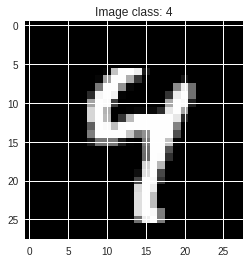

In [8]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.imshow(x_train[2].reshape((28,28)), cmap = 'gray')
plt.title('Image class: ' + str(y_train[2]))

# Building our convoltional neural network

In [0]:
import tensorflow as tf

In [0]:
def cnn(features, labels, mode):
    # batch_size, matrix width, matrix height, matrix channels
    data = tf.reshape(features['X'], [-1, 28, 28, 1])
    
    # input [batch_size, 28, 28, 1]
    # output [batch_size, 28, 28, 32]
    conv1 = tf.layers.conv2d(inputs = data, filters = 32, kernel_size=[5,5], activation = tf.nn.relu,
                                  padding = 'same')
    # input [batch_size, 28, 28, 32]
    # output [batch_size, 14, 14, 32]
    pool1 = tf.layers.max_pooling2d(inputs = conv1, pool_size = [2,2], strides = 2)
    
    # input [batch_size, 14, 14, 32]
    # output [batch_size, 14, 14, 64]
    conv2 = tf.layers.conv2d(inputs = pool1, filters = 64, kernel_size = [5,5], activation = tf.nn.relu,
                                  padding = 'same')
    # input [batch_size, 14, 14, 64]
    # h = (14-2)/2+1 = 7
    # w = (14-2)/2+1 = 7
    # d = 64 * 1 = 64
    # output [batch_size, 7, 7, 64]
    pool2 = tf.layers.max_pooling2d(inputs = conv2, pool_size = [2,2], strides = 2)
    
    # input [batch_size, 7, 7, 64]
    # output [batch_size, 3136]
    flattening = tf.reshape(pool2, [-1, 7 * 7 * 64])
    
    # 3136 (input) -> 1024 (hidden) -> 10 (output)
    # input [batch_size, 3136]
    # output [batch_size, 1024]
    dense = tf.layers.dense(inputs = flattening, units = 1024, activation = tf.nn.relu)
    
    # dropout
    dropout = tf.layers.dropout(inputs = dense, rate = 0.2, training=mode == tf.estimator.ModeKeys.TRAIN)
    
    # input [batch_size, 1024]
    # output [batch_size, 10]
    output = tf.layers.dense(inputs = dropout, units = 10)
    
    # 0.2 0.2 0.6 - 2
    predictions = tf.argmax(output, axis = 1)
    
    if mode == tf.estimator.ModeKeys.PREDICT:
        return tf.estimator.EstimatorSpec(mode = mode, predictions = output)
    
    error = tf.losses.sparse_softmax_cross_entropy(labels = labels, logits = output)
    
    if mode == tf.estimator.ModeKeys.TRAIN:
        optimizer = tf.train.AdamOptimizer(learning_rate = 0.001)
        training = optimizer.minimize(error, global_step = tf.train.get_global_step())
        return tf.estimator.EstimatorSpec(mode = mode, loss = error, train_op = training)
    
    if mode == tf.estimator.ModeKeys.EVAL:
        eval_metrics_ops = {'accuracy': tf.metrics.accuracy(labels = labels, predictions = predictions)}
        return tf.estimator.EstimatorSpec(mode = mode, loss = error, eval_metric_ops = eval_metrics_ops)
    

### Formules explanation

#### [Convolution]
H = (H-F+2P)/S+1<br>
W = (W-F+2P)/S+1<br>
D = K

#### [Pooling]
H = (H-F)/S+1<br>
W = (W-F)/S+1<br>
D = D * 1

#### [Glossary]
H: Heights<br>
W: Weights<br>
D: Dimentions<br>
K: Filters<br>
F: Filter extention(WxH)<br>
P: Padding**

#### [Flattening]
[1,2
3,4] --> [1,2,3,4]

#### [Dropout]
Delete some random neurons on dense layer


In [11]:
classifier = tf.estimator.Estimator(model_fn = cnn)

INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_model_dir': '/tmp/tmpps2ecufw', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x7fc659b58cc0>, '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


# Train our model with a estimator

In [12]:
train_fn = tf.estimator.inputs.numpy_input_fn(x = {'X': x_train}, y = y_train,
                                                       batch_size = 128, num_epochs = None, shuffle = True)
classifier.train(input_fn=train_fn, steps = 200)

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
To construct input pipelines, use the `tf.data` module.
Instructions for updating:
To construct input pipelines, use the `tf.data` module.
INFO:tensorflow:Calling model_fn.
Instructions for updating:
Use keras.layers.conv2d instead.
Instructions for updating:
Use keras.layers.max_pooling2d instead.
Instructions for updating:
Use keras.layers.dense instead.
Instructions for updating:
Use keras.layers.dropout instead.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Instructions for updating:
Use tf.cast instead.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
Instructions for updating:
To construct input pipelines, use the `tf.data` module.
INFO:tensorflow:Saving checkpoin

# Testing a estimator with our CNN

In [13]:
test_fn = tf.estimator.inputs.numpy_input_fn(x = {'X': x_test}, y = y_test, num_epochs = 1,
                                                      shuffle = False)
output = classifier.evaluate(input_fn=test_fn)

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Starting evaluation at 2019-03-29T16:33:08Z
INFO:tensorflow:Graph was finalized.
Instructions for updating:
Use standard file APIs to check for files with this prefix.
INFO:tensorflow:Restoring parameters from /tmp/tmpps2ecufw/model.ckpt-200
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Finished evaluation at 2019-03-29-16:33:08
INFO:tensorflow:Saving dict for global step 200: accuracy = 0.9783, global_step = 200, loss = 0.06768881
INFO:tensorflow:Saving 'checkpoint_path' summary for global step 200: /tmp/tmpps2ecufw/model.ckpt-200


In [14]:
classifier

# Predicting a image and visualizng it

In [16]:
x_test[1].shape
x_imagem_test = x_test[1].reshape(1,-1)
x_imagem_test.shape

(1, 784)

In [19]:
predict_fc = tf.estimator.inputs.numpy_input_fn(x = {'X': x_imagem_test}, shuffle=False)
pred = list(classifier.predict(input_fn = predict_fc))

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /tmp/tmpps2ecufw/model.ckpt-200
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.


Text(0.5, 1.0, 'Classe prevista: [ 1.6107465  6.1295943 12.503491   1.3028429 -3.9985301 -6.365043\n -0.7460242 -6.7919564  1.8091372 -9.258843 ]')

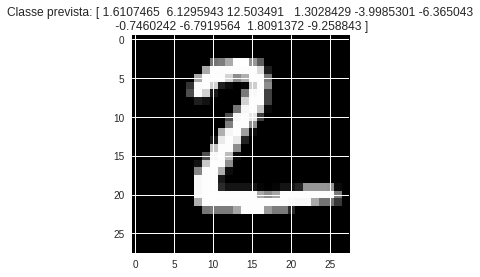

In [21]:
plt.imshow(x_imagem_test.reshape((28, 28)), cmap = 'gray')
plt.title('Classe prevista: ' + str(pred[0]))